# Preprocessing scRNA-seq from trophoblast organoid experiments 
### (both #1 and #2)

05.2021

This is a preprocessing notebook, so this happens here:

Step-by-step workflow:

- load
- filter genes, cells, add info
- perform **step 1** of calling doublets using Krzysztof's bertie doublet caller:
    - see bertie_doublet_caller.ipynb in /home/jovyan/ and read comments
- concatenate
- add doublet scores from saved tables (bertie)
- filter MT-high cells
- make cells (obs) and var (genes) unique
- parsing souporcell deconvolution results
- save preprocessed object

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
import bbknn
import scrublet as scr
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
annoy               NA
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bbknn               NA
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyte

In [4]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202105_troph_organoids_exp_1_2/'

A Benjamini-Hochberg function for later. Running FDR is surprisingly inconvenient using built-in Python options.

In [5]:
def bh(pvalues):
    '''
    Computes the Benjamini-Hochberg FDR correction.
    
    Input:
        * pvals - vector of p-values to correct
    '''
    n = int(pvalues.shape[0])
    new_pvalues = np.empty(n)
    values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]
    values.sort()
    values.reverse()
    new_values = []
    for i, vals in enumerate(values):
        rank = n - i
        pvalue, index = vals
        new_values.append((n/rank) * pvalue)
    for i in range(0, int(n)-1):
        if new_values[i] < new_values[i+1]:
            new_values[i+1] = new_values[i]
    for i, vals in enumerate(values):
        pvalue, index = vals
        new_pvalues[index] = new_values[i]
    return new_pvalues

In [6]:
###################
# doublet calling #
###################

def bertie(adata_sample, sample):
    
    scorenames = ['scrublet_score','scrublet_cluster_score','bh_pval']
    
    adata_sample_copy = adata_sample.copy()
    # set up and run Scrublet
    scrub = scr.Scrublet(adata_sample_copy.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)
    adata_sample_copy.obs['scrublet_score'] = doublet_scores
    
    # overcluster prep. run turbo basic scanpy pipeline
    sc.pp.normalize_per_cell(adata_sample_copy, counts_per_cell_after=1e4)
    sc.pp.log1p(adata_sample_copy)
    sc.pp.highly_variable_genes(adata_sample_copy, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata_sample_copy = adata_sample_copy[:, adata_sample_copy.var['highly_variable']]
    adata_sample_copy = adata_sample_copy.copy()
    sc.pp.scale(adata_sample_copy, max_value=10)
    sc.tl.pca(adata_sample_copy, svd_solver='arpack')
    sc.pp.neighbors(adata_sample_copy)
    
    # overclustering proper - do basic clustering first, then cluster each cluster
    sc.tl.louvain(adata_sample_copy)
    for clus in np.unique(adata_sample_copy.obs['louvain']):
        sc.tl.louvain(adata_sample_copy, restrict_to=('louvain',[clus]))
        adata_sample_copy.obs['louvain'] = adata_sample_copy.obs['louvain_R']
        
    # compute the cluster scores - the median of Scrublet scores per overclustered cluster
    for clus in np.unique(adata_sample_copy.obs['louvain']):
        adata_sample_copy.obs.loc[adata_sample_copy.obs['louvain']==clus, 'scrublet_cluster_score'] = \
            np.median(adata_sample_copy.obs.loc[adata_sample_copy.obs['louvain']==clus, 'scrublet_score'])
        
    # now compute doublet p-values. figure out the median and mad (from above-median values) for the distribution
    med = np.median(adata_sample_copy.obs['scrublet_cluster_score'])
    mask = adata_sample_copy.obs['scrublet_cluster_score']>med
    mad = np.median(adata_sample_copy.obs['scrublet_cluster_score'][mask]-med)
    
    #let's do a one-sided test. the Bertie write-up does not address this but it makes sense
    pvals = 1-scipy.stats.norm.cdf(adata_sample_copy.obs['scrublet_cluster_score'], loc=med, scale=1.4826*mad)
    adata_sample_copy.obs['bh_pval'] = bh(pvals)
    
    # getting calculated values to the initial object with raw count values
    for col in scorenames:
        adata_sample.obs[col] = adata_sample_copy.obs[col]
    
    return adata_sample.obs[scorenames]

### Reading and preprocessing

In [7]:
samples_experiment_1 = ['6044STDY8640561',
                      '6044STDY8640562',
                      '6044STDY8640563',
                      '6044STDY8640564',
                      '6044STDY8640565',
                      '6044STDY8640566'
                       ]

samples_experiment_2 = ['Pla_Camb10123928',
                        'Pla_Camb10123929',
                        'Pla_Camb10123930',
                        'Pla_Camb10123931',
                        'Pla_Camb10123932',
                        'Pla_Camb10123933',
                        'Pla_Camb10123934',
                        'Pla_Camb10123935'
                       ]



In [8]:
# Annotation / metadata
sample_to_timepoint_cytokine_medium = {}

# medium is either EVT medium or TOM (undifferentiated control)
# in all samples there are 3 individuals multiplexed:
# donors 0, 1 and 2 in experiment 1 samples
# donors 3, 4, 5 in experiment 2 samples 
# I. e. no donors are shared between experiment 1 and 2

sample_to_timepoint_cytokine_medium['6044STDY8640561'] = ['3H', 'no_cytokines', 'EVTM']
sample_to_timepoint_cytokine_medium['6044STDY8640562'] = ['3H', 'cytokines', 'EVTM']
sample_to_timepoint_cytokine_medium['6044STDY8640563'] = ['24H', 'no_cytokines', 'EVTM']
sample_to_timepoint_cytokine_medium['6044STDY8640564'] = ['24H', 'cytokines', 'EVTM']
sample_to_timepoint_cytokine_medium['6044STDY8640565'] = ['48H', 'no_cytokines', 'EVTM']
sample_to_timepoint_cytokine_medium['6044STDY8640566'] = ['48H', 'cytokines', 'EVTM']


sample_to_timepoint_cytokine_medium['Pla_Camb10123928'] = ['-48H', 'no_cytokines', 'EVTM']
sample_to_timepoint_cytokine_medium['Pla_Camb10123929'] = ['0H', 'no_cytokines', 'EVTM']
sample_to_timepoint_cytokine_medium['Pla_Camb10123930'] = ['48H', 'no_cytokines', 'EVTM']
sample_to_timepoint_cytokine_medium['Pla_Camb10123931'] = ['48H', 'cytokines', 'EVTM']
sample_to_timepoint_cytokine_medium['Pla_Camb10123932'] = ['96H', 'no_cytokines', 'EVTM']
sample_to_timepoint_cytokine_medium['Pla_Camb10123933'] = ['96H', 'cytokines', 'EVTM']
sample_to_timepoint_cytokine_medium['Pla_Camb10123934'] = ['96H', 'no_cytokines', 'TOM'] # TOM, undiff control
sample_to_timepoint_cytokine_medium['Pla_Camb10123935'] = ['96H', 'cytokines', 'TOM'] # TOM, undiff control



In [1]:
%%time

# to see how many cells cellranger called

holder = []

all_samples = samples_experiment_1 + samples_experiment_2 #+ samples_Roser

for sample in all_samples:
    print('sample', sample,
          "from scRNA-seq samples", list(all_samples).index(sample)+1,
          'out of', len(all_samples))
    
    if sample in samples_experiment_1:
        path = '/lustre/scratch117/cellgen/team292/aa22/data/201911_troph_organoids_experiment_1_cellranger/cellranger302_count_32734_' + sample + '_GRCh38-3_0_0/filtered_feature_bc_matrix.h5'
    elif sample in samples_experiment_2:
        path = '/lustre/scratch117/cellgen/team292/aa22/data/202104_placental_organoids_experiment_2/cellranger302_count_37295_' + sample + '_GRCh38-3_0_0/filtered_feature_bc_matrix.h5'
    
    holder.append(sc.read_10x_h5(path))
    
    holder[-1].var_names_make_unique()
    
adata_count_cellranger = holder[0].concatenate(holder[1:],join='outer',index_unique=None)

NameError: name 'samples_experiment_1' is not defined

In [10]:
adata_count_cellranger

AnnData object with n_obs × n_vars = 130400 × 33538
    obs: 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

This is happening in the cell below:
- read the raw file (output of cellranger)
- call doublets according to bertie doublet caller and adding all the scores
- Filter: 1) cells (< 500 genes); 2) genes (< 3 cells); 
- Add %mt genes
- Add relevant annotation info

In [11]:
%%time

holder = []

# for doublets
scorenames = ['scrublet_score','scrublet_cluster_score','bh_pval']
#os.makedirs('scrublet_scores')

all_samples = samples_experiment_1 + samples_experiment_2 #+ samples_Roser

for sample in all_samples:
    print('sample', sample,
          "from scRNA-seq samples", list(all_samples).index(sample)+1,
          'out of', len(all_samples))
    
    if sample in samples_experiment_1:
        path = '/lustre/scratch117/cellgen/team292/aa22/data/201911_troph_organoids_experiment_1_cellranger/cellranger302_count_32734_' + sample + '_GRCh38-3_0_0/filtered_feature_bc_matrix.h5'
    elif sample in samples_experiment_2:
        path = '/lustre/scratch117/cellgen/team292/aa22/data/202104_placental_organoids_experiment_2/cellranger302_count_37295_' + sample + '_GRCh38-3_0_0/filtered_feature_bc_matrix.h5'
    
    holder.append(sc.read_10x_h5(path))
    
    holder[-1].var_names_make_unique()
    
    # Filer cells with less than 200 genes expressed
    sc.pp.filter_cells(holder[-1], min_genes=200)
    
    # Filer genes expressed in less than 3 cells
    sc.pp.filter_genes(holder[-1], min_cells=3)
    
    # Adding metadata information
    
    curr_info = sample_to_timepoint_cytokine_medium[sample]
    
    holder[-1].obs['time_point'] = curr_info[0]
    holder[-1].obs['activation_status'] = curr_info[1]
    holder[-1].obs['media'] = curr_info[2]
    #print('this was tissue block', block, 'sample:', sample)
    
    # Sample information
    holder[-1].obs['sample'] = sample
    # In cell_id we save barcode+sample index, to be unique in the future
    holder[-1].obs['barcode_sample'] = [i+'_'+j for i,j in zip(holder[-1].obs.index, holder[-1].obs['sample'])]
    
    # Extract mitochondial genes
    mito_genes = [name for name in holder[-1].var_names if name.startswith('MT-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
        holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
    
    holder[-1].obs['dataset'] = 'scRNA-seq'
    holder[-1].obs['technique'] = '10X'
    
    
    # calling doublets on current sample's adata which is holder[-1]
    print('going on to call doublets (write doublet scores into tables) with bertie')
    scores_table = bertie(holder[-1], sample)
    if list(scores_table.index) == list(holder[-1].obs.index):
        print('indices in current bertie table and sample adata are matching, assigning scores')
        for meta in scorenames:
            holder[-1].obs[meta] = scores_table[meta]
    else:
        print('indices in current bertie table and sample adata are NOT matching')

reading /home/jovyan/notebooks/Vento_Lab/Placental_Organoids/201911_experiment_1_pilot/rawdata/filtered_feature_bc_matrix_6044STDY8640561.h5


sample 6044STDY8640561 from scRNA-seq samples 1 out of 14


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 967 cells that have less than 200 genes expressed
filtered out 14419 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample 6044STDY8640562 from scRNA-seq samples 2 out of 14


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 35 cells that have less than 200 genes expressed
filtered out 13668 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:16)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample 6044STDY8640563 from scRNA-seq samples 3 out of 14


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 522 cells that have less than 200 genes expressed
filtered out 13990 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:13)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample 6044STDY8640564 from scRNA-seq samples 4 out of 14


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 599 cells that have less than 200 genes expressed
filtered out 13686 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:13)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample 6044STDY8640565 from scRNA-seq samples 5 out of 14


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 265 cells that have less than 200 genes expressed
filtered out 13882 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:14)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample 6044STDY8640566 from scRNA-seq samples 6 out of 14


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 720 cells that have less than 200 genes expressed
filtered out 14188 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:14)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_Camb10123928 from scRNA-seq samples 7 out of 14


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 7 cells that have less than 200 genes expressed
filtered out 14043 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_Camb10123929 from scRNA-seq samples 8 out of 14


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:04)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 10 cells that have less than 200 genes expressed
filtered out 13165 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:11)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_Camb10123930 from scRNA-seq samples 9 out of 14


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 14107 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_Camb10123931 from scRNA-seq samples 10 out of 14


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:07)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 13734 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:11)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_Camb10123932 from scRNA-seq samples 11 out of 14


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 3 cells that have less than 200 genes expressed
filtered out 15276 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:11)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running 

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_Camb10123933 from scRNA-seq samples 12 out of 14


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:10)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 2 cells that have less than 200 genes expressed
filtered out 14577 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:12)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running 

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_Camb10123934 from scRNA-seq samples 13 out of 14


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 244 cells that have less than 200 genes expressed
filtered out 13753 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:11)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_Camb10123935 from scRNA-seq samples 14 out of 14


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:18)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 167 cells that have less than 200 genes expressed
filtered out 13620 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:12)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
CPU times: user 36min 18s, sys: 17min 30s, total: 53min 49s
Wall time: 9min 39s


# QC, cutoff decisions and reading again

In [11]:
%%time
# concatenate all samples into 1 object
# about 3 minutes
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


CPU times: user 1.17 s, sys: 560 ms, total: 1.73 s
Wall time: 1.72 s


In [12]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)  

In [13]:
# median of dtected genes
np.median(adata.obs['n_genes'])

2046.0

... storing 'time_point' as categorical
... storing 'activation_status' as categorical
... storing 'media' as categorical
... storing 'sample' as categorical
... storing 'dataset' as categorical
... storing 'technique' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


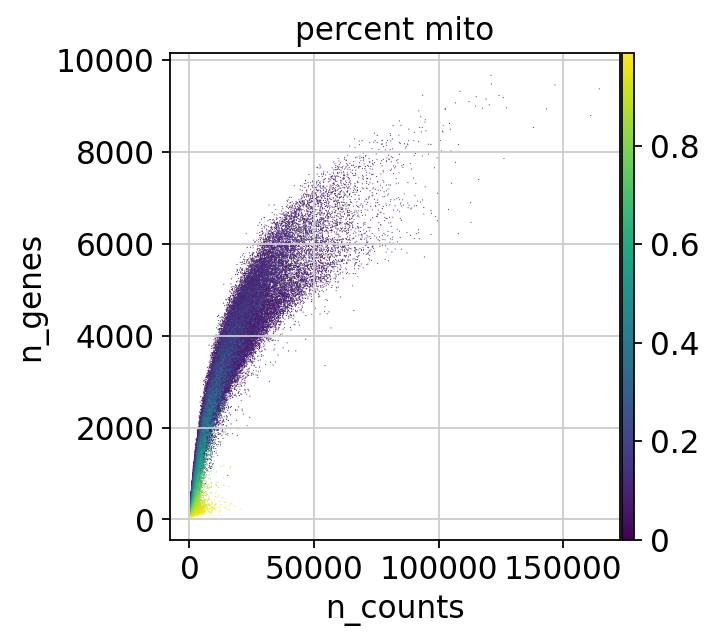

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


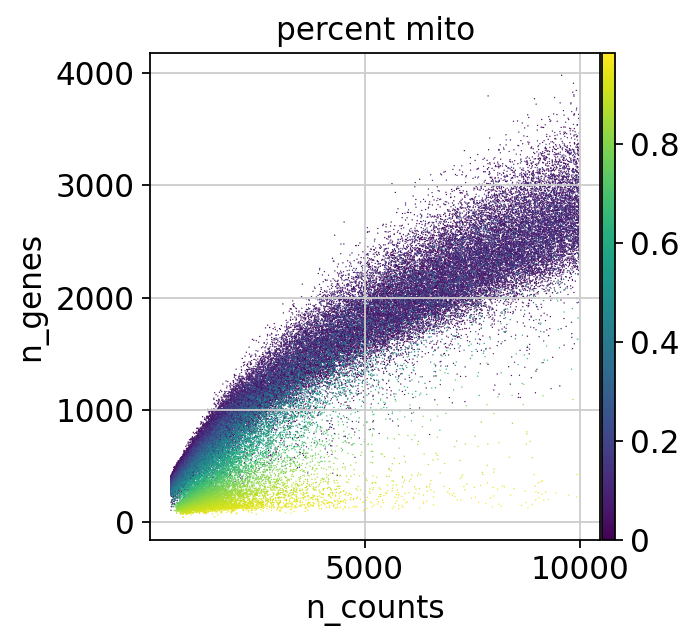

In [14]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='percent_mito')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='percent_mito')


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


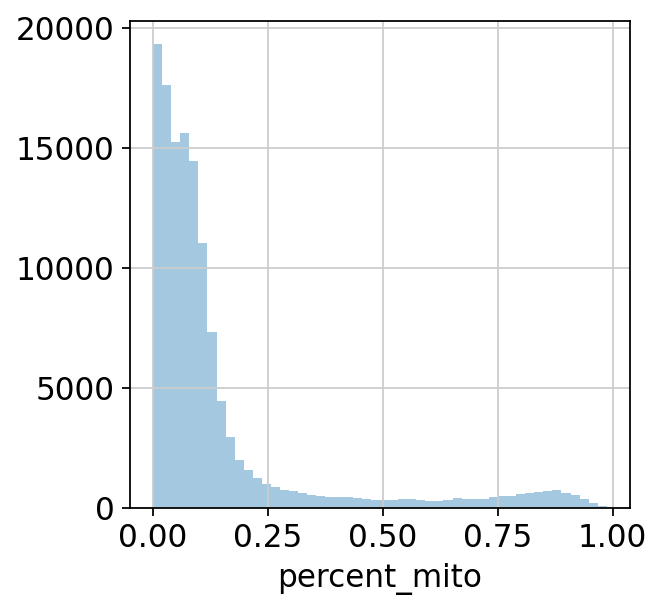

In [15]:
p3 = sns.distplot(adata.obs['percent_mito'], kde=False)
plt.show()

In [16]:
np.percentile(list(adata.obs['percent_mito']),20)

0.026714677736163147

In [17]:
len(adata[adata.obs['percent_mito'] > 0.2])

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


20278

In [18]:
len(adata[adata.obs['percent_mito'] > 0.2])/len(adata.obs)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


0.15550613496932517

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


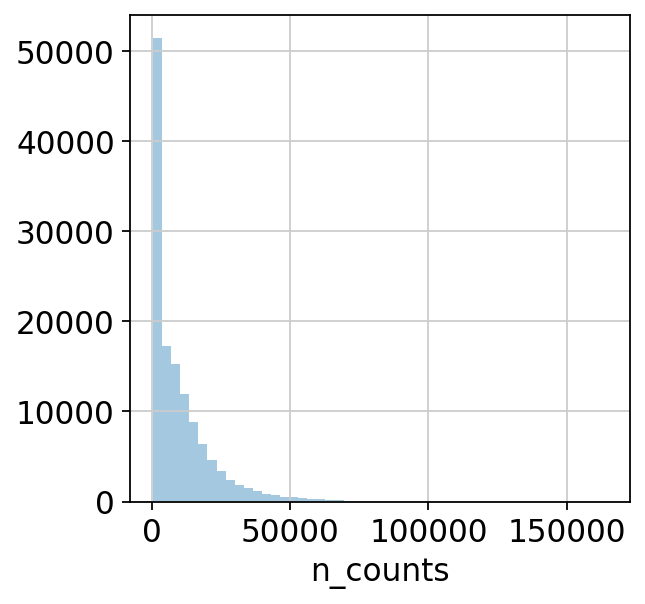

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


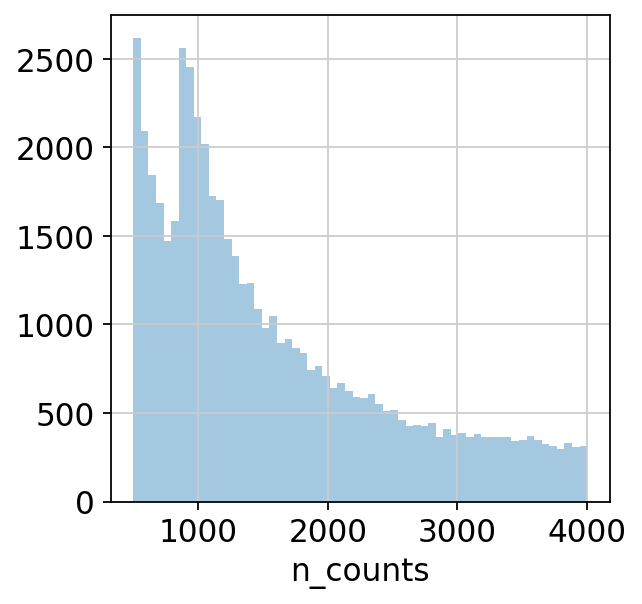

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


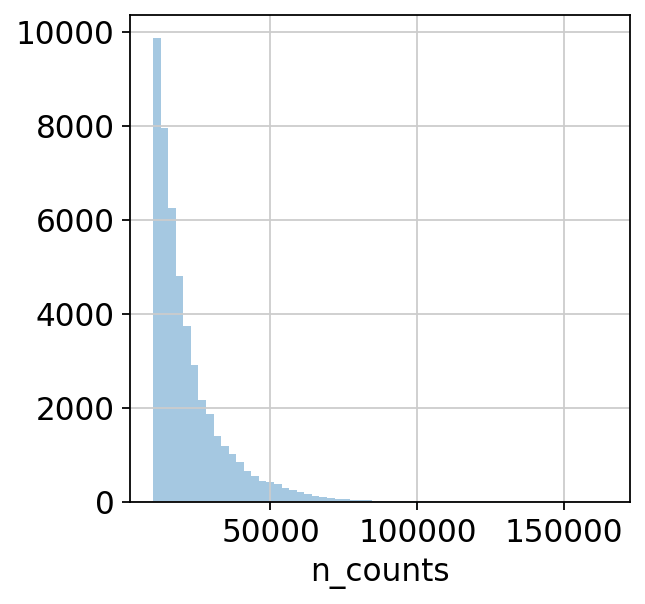

In [19]:
# Thresholding decision: counts
p3 = sns.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
plt.show()


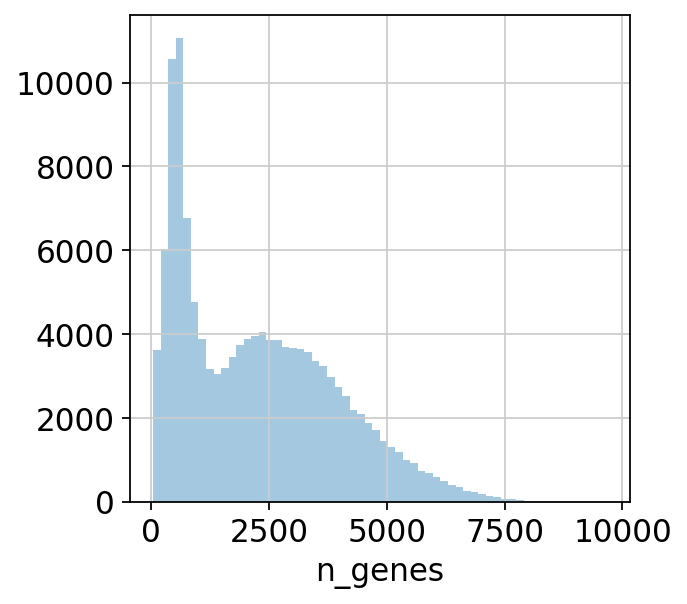

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


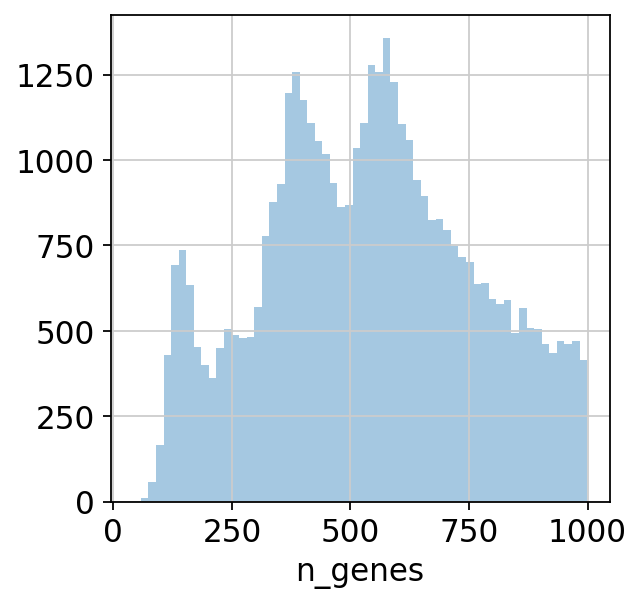

In [20]:
# Thresholding decision: genes
p6 = sns.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

**Desicion**: gene cutoff: min_genes=200, min_cells=3, going back up to reread and filter there

In [21]:
np.unique(adata.obs['sample'])

array(['6044STDY8640561', '6044STDY8640562', '6044STDY8640563',
       '6044STDY8640564', '6044STDY8640565', '6044STDY8640566',
       'Pla_Camb10123928', 'Pla_Camb10123929', 'Pla_Camb10123930',
       'Pla_Camb10123931', 'Pla_Camb10123932', 'Pla_Camb10123933',
       'Pla_Camb10123934', 'Pla_Camb10123935'], dtype=object)

In [22]:
# quick check to see if raw is raw or not
expr_mtx_dense = adata[adata.obs['sample'] == 'Pla_Camb10123928'].X.todense()

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [23]:
# YAS we all good
np.unique(expr_mtx_dense)

matrix([[    0.,     0.,     0., ..., 13146., 26412., 30230.]],
       dtype=float32)

____________________________________________________________________________________________________________

Carrying on to:
- Concatenate

In [12]:
%%time

adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)
adata.X = adata.X.tocsr()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


CPU times: user 4.76 s, sys: 766 ms, total: 5.53 s
Wall time: 5.53 s


In [13]:
# saving corrected metadata table
#metadata_corrected = adata.obs
#metadata_corrected.to_csv('metadata_corrected_20200630.csv')

Carrying on to 
- Filter MT-high cells (>20%)
- Save raw attribute
- Make cell names (obs) and gene names (var) unique

In [14]:
# mt % filtering
adata = adata[adata.obs['percent_mito'] < 0.2]

# saving the raw attribute
adata.raw = adata.copy()

adata.var_names_make_unique()
adata.obs_names_make_unique()

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [15]:
# adding 'is_doublet' annotation by throsholding the bh_pvalue, this is not the end of doublet calling
# this parameter can be tweaked according to how harsh the detection needs to be
# the less it is, the less doublets it will call
adata.obs['is_doublet'] = adata.obs['bh_pval'] < 0.1

Second step of bertie doublet removal - will be done later in the pipeline

_____________________________________________________________________________________________________________________________________________________________

In [16]:
adata

AnnData object with n_obs × n_vars = 110095 × 23281
    obs: 'n_genes', 'time_point', 'activation_status', 'media', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'gene_

In [17]:
np.unique(adata.obs['sample'])

array(['6044STDY8640561', '6044STDY8640562', '6044STDY8640563',
       '6044STDY8640564', '6044STDY8640565', '6044STDY8640566',
       'Pla_Camb10123928', 'Pla_Camb10123929', 'Pla_Camb10123930',
       'Pla_Camb10123931', 'Pla_Camb10123932', 'Pla_Camb10123933',
       'Pla_Camb10123934', 'Pla_Camb10123935'], dtype=object)

In [18]:
# also add experiment batch
adata.obs['experiment'] = ['1' if elem in ['6044STDY8640561', '6044STDY8640562', '6044STDY8640563',
       '6044STDY8640564', '6044STDY8640565', '6044STDY8640566'] else '2' for elem in list(adata.obs['sample'])]

In [19]:
np.unique(adata.obs['experiment'], return_counts=True)

(array(['1', '2'], dtype=object), array([50495, 59600]))

In [20]:
expr_mtx_dense = adata[adata.obs['sample'] == 'Pla_Camb10123928'].X.todense()

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [21]:
# YAS we good!
np.unique(expr_mtx_dense)

matrix([[    0.,     0.,     0., ..., 13146., 26412., 30230.]],
       dtype=float32)

In [22]:
# let's save the object here before calling any doublets
adata.write(save_path + 'adata_raw_filtered_before_any_doublet_exclusion.h5ad')

... storing 'time_point' as categorical
... storing 'activation_status' as categorical
... storing 'media' as categorical
... storing 'sample' as categorical
... storing 'dataset' as categorical
... storing 'technique' as categorical
... storing 'experiment' as categorical
... storing 'gene_ids-0' as categorical
... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical
... storing 'gene_ids-1' as categorical
... storing 'feature_types-1' as categorical
... storing 'genome-1' as categorical
... storing 'gene_ids-10' as categorical
... storing 'feature_types-10' as categorical
... storing 'genome-10' as categorical
... storing 'gene_ids-11' as categorical
... storing 'feature_types-11' as categorical
... storing 'genome-11' as categorical
... storing 'gene_ids-12' as categorical
... storing 'feature_types-12' as categorical
... storing 'genome-12' as categorical
... storing 'gene_ids-13' as categorical
... storing 'feature_types-13' as categorical
... storing 'ge

In [23]:
save_path

'/lustre/scratch117/cellgen/team292/aa22/adata_objects/202105_troph_organoids_exp_1_2/'

# Adding donor deconvolution

### Adding `souporcell` results

#### Without remapping reads, using common variants file

(with Simon Murray from cellgen IT, 05.2021)

In [22]:
np.unique(adata.obs['sample'], return_counts=True)

(array(['6044STDY8640561', '6044STDY8640562', '6044STDY8640563',
        '6044STDY8640564', '6044STDY8640565', '6044STDY8640566',
        'Pla_Camb10123928', 'Pla_Camb10123929', 'Pla_Camb10123930',
        'Pla_Camb10123931', 'Pla_Camb10123932', 'Pla_Camb10123933',
        'Pla_Camb10123934', 'Pla_Camb10123935'], dtype=object),
 array([ 7019,  8242,  9150,  8538,  8642,  8904,  4196,  7640,  9295,
        12541,  4417,  6562,  7383,  7566]))

In [30]:
souporcell_dirs = {}

prefix_experiment_1 = '/lustre/scratch117/cellgen/team292/aa22/souporcell_analyses/souporcell_scRNA-seq_pilot_experiment_organoids_201911_with_common_variants/no-remap/souporcell/'
prefix_experiment_2 = '/lustre/scratch117/cellgen/team292/aa22/souporcell_analyses/souporcell_scRNA-seq_troph_organoids_experiment_2_with_common_variants/results/souporcell/'

souporcell_dirs['6044STDY8640561'] = prefix_experiment_1 + '6044STDY8640561/'
souporcell_dirs['6044STDY8640562'] = prefix_experiment_1 + '6044STDY8640562/'
souporcell_dirs['6044STDY8640563'] = prefix_experiment_1 + '6044STDY8640563/'
souporcell_dirs['6044STDY8640564'] = prefix_experiment_1 + '6044STDY8640564/'
souporcell_dirs['6044STDY8640565'] = prefix_experiment_1 + '6044STDY8640565/'
souporcell_dirs['6044STDY8640566'] = prefix_experiment_1 + '6044STDY8640566/'

souporcell_dirs['Pla_Camb10123928'] = prefix_experiment_2 + 'Pla_Camb10123928/'
souporcell_dirs['Pla_Camb10123929'] = prefix_experiment_2 + 'Pla_Camb10123929/'
souporcell_dirs['Pla_Camb10123930'] = prefix_experiment_2 + 'Pla_Camb10123930/'
souporcell_dirs['Pla_Camb10123931'] = prefix_experiment_2 + 'Pla_Camb10123931/'
souporcell_dirs['Pla_Camb10123932'] = prefix_experiment_2 + 'Pla_Camb10123932/'
souporcell_dirs['Pla_Camb10123933'] = prefix_experiment_2 + 'Pla_Camb10123933/'
souporcell_dirs['Pla_Camb10123934'] = prefix_experiment_2 + 'Pla_Camb10123934/'
souporcell_dirs['Pla_Camb10123935'] = prefix_experiment_2 + 'Pla_Camb10123935/'

In [31]:
holder = []

for sample in list(souporcell_dirs.keys()):
    print('sample ', sample)
    curr_table = pd.read_csv(souporcell_dirs[sample]+'clusters.tsv', sep='\t', index_col=0)
    curr_table['barcode_sample'] = [i+'_'+sample for i in curr_table.index]
    print('len of curr table is', len(curr_table))
    holder.append(curr_table)
    

sample  6044STDY8640561
len of curr table is 9799
sample  6044STDY8640562
len of curr table is 11474
sample  6044STDY8640563
len of curr table is 11035
sample  6044STDY8640564
len of curr table is 10503
sample  6044STDY8640565
len of curr table is 10735
sample  6044STDY8640566
len of curr table is 10975
sample  Pla_Camb10123928
len of curr table is 5171
sample  Pla_Camb10123929
len of curr table is 8071
sample  Pla_Camb10123930
len of curr table is 9886
sample  Pla_Camb10123931
len of curr table is 13357
sample  Pla_Camb10123932
len of curr table is 4806
sample  Pla_Camb10123933
len of curr table is 7364
sample  Pla_Camb10123934
len of curr table is 8492
sample  Pla_Camb10123935
len of curr table is 8732


In [32]:
souporcell_meta_table = pd.concat(holder,join='outer')

In [33]:
souporcell_meta_table

,status,assignment,log_prob_singleton,log_prob_doublet,cluster0,cluster1,cluster2,barcode_sample
barcode,,,,,,,,
AAACCCAAGCTAGTTC-1,singlet,1,-140.994785,-152.048246,-416.244267,-140.994785,-357.576766,AAACCCAAGCTAGTTC-1_6044STDY8640561
AAACCCAAGGACATCG-1,doublet,2/0,-97.629486,-78.549165,-133.901851,-165.845238,-97.629486,AAACCCAAGGACATCG-1_6044STDY8640561
AAACCCACAAAGTGTA-1,singlet,1,-499.827264,-582.087357,-2354.063643,-499.827264,-1895.611152,AAACCCACAAAGTGTA-1_6044STDY8640561
AAACCCAGTGCACGCT-1,singlet,1,-170.345683,-190.344043,-686.949730,-170.345683,-539.492288,AAACCCAGTGCACGCT-1_6044STDY8640561
AAACCCAGTTGGCCTG-1,singlet,1,-278.332563,-303.750103,-1005.031905,-278.332563,-848.976918,AAACCCAGTTGGCCTG-1_6044STDY8640561
...,...,...,...,...,...,...,...,...
TTTGTTGCATGATAGA-1,singlet,0,-560.657000,-652.025537,-560.657000,-1921.420601,-2086.702406,TTTGTTGCATGATAGA-1_Pla_Camb10123935
TTTGTTGCATTAGGAA-1,doublet,1/0,-46.316364,-38.700523,-79.981618,-46.316364,-111.592485,TTTGTTGCATTAGGAA-1_Pla_Camb10123935
TTTGTTGGTGCTCCGA-1,singlet,2,-775.049378,-1309.068771,-2550.791183,-2171.371980,-775.049378,TTTGTTGGTGCTCCGA-1_Pla_Camb10123935


In [34]:
souporcell_meta_table.set_index('barcode_sample', inplace=True, drop=False)

In [35]:
souporcell_meta_table.index

Index(['AAACCCAAGCTAGTTC-1_6044STDY8640561',
       'AAACCCAAGGACATCG-1_6044STDY8640561',
       'AAACCCACAAAGTGTA-1_6044STDY8640561',
       'AAACCCAGTGCACGCT-1_6044STDY8640561',
       'AAACCCAGTTGGCCTG-1_6044STDY8640561',
       'AAACCCATCTCGACGG-1_6044STDY8640561',
       'AAACGAAAGCGCCTTG-1_6044STDY8640561',
       'AAACGAAAGCTCCACG-1_6044STDY8640561',
       'AAACGAAAGTCTCGTA-1_6044STDY8640561',
       'AAACGAACAACCACGC-1_6044STDY8640561',
       ...
       'TTTGTTGCAAGCCTGC-1_Pla_Camb10123935',
       'TTTGTTGCACAACGCC-1_Pla_Camb10123935',
       'TTTGTTGCACCTGATA-1_Pla_Camb10123935',
       'TTTGTTGCAGGTTCGC-1_Pla_Camb10123935',
       'TTTGTTGCAGTTGCGC-1_Pla_Camb10123935',
       'TTTGTTGCATGATAGA-1_Pla_Camb10123935',
       'TTTGTTGCATTAGGAA-1_Pla_Camb10123935',
       'TTTGTTGGTGCTCCGA-1_Pla_Camb10123935',
       'TTTGTTGTCCCAACTC-1_Pla_Camb10123935',
       'TTTGTTGTCTTTGCTA-1_Pla_Camb10123935'],
      dtype='object', name='barcode_sample', length=130400)

In [36]:
adata.obs

,n_genes,time_point,activation_status,media,sample,barcode_sample,percent_mito,n_counts,dataset,technique,scrublet_score,scrublet_cluster_score,bh_pval,batch,is_doublet,experiment
AAACCCAAGCTAGTTC-1,715,3H,no_cytokines,EVTM,6044STDY8640561,AAACCCAAGCTAGTTC-1_6044STDY8640561,0.016393,1220.0,scRNA-seq,10X,0.025670,0.050578,0.997454,0,False,1
AAACCCAAGGACATCG-1,1319,3H,no_cytokines,EVTM,6044STDY8640561,AAACCCAAGGACATCG-1_6044STDY8640561,0.175336,2749.0,scRNA-seq,10X,0.200000,0.225007,0.000664,0,True,1
AAACCCACAAAGTGTA-1,3765,3H,no_cytokines,EVTM,6044STDY8640561,AAACCCACAAAGTGTA-1_6044STDY8640561,0.067086,18931.0,scRNA-seq,10X,0.173047,0.088608,0.997454,0,False,1
AAACCCAGTGCACGCT-1,2116,3H,no_cytokines,EVTM,6044STDY8640561,AAACCCAGTGCACGCT-1_6044STDY8640561,0.005407,6288.0,scRNA-seq,10X,0.056231,0.101911,0.966822,0,False,1
AAACCCAGTTGGCCTG-1,2672,3H,no_cytokines,EVTM,6044STDY8640561,AAACCCAGTTGGCCTG-1_6044STDY8640561,0.111556,10999.0,scRNA-seq,10X,0.054764,0.099062,0.966822,0,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAGGTTCGC-1,3703,96H,cytokines,TOM,Pla_Camb10123935,TTTGTTGCAGGTTCGC-1_Pla_Camb10123935,0.165256,14063.0,scRNA-seq,10X,0.142857,0.152639,0.773329,13,False,2
TTTGTTGCAGTTGCGC-1,4898,96H,cytokines,TOM,Pla_Camb10123935,TTTGTTGCAGTTGCGC-1_Pla_Camb10123935,0.075124,22616.0,scRNA-seq,10X,0.169231,0.211679,0.773329,13,False,2
TTTGTTGCATGATAGA-1-1,3912,96H,cytokines,TOM,Pla_Camb10123935,TTTGTTGCATGATAGA-1_Pla_Camb10123935,0.050489,15231.0,scRNA-seq,10X,0.072824,0.081285,0.970709,13,False,2
TTTGTTGGTGCTCCGA-1,5572,96H,cytokines,TOM,Pla_Camb10123935,TTTGTTGGTGCTCCGA-1_Pla_Camb10123935,0.144372,27540.0,scRNA-seq,10X,0.118280,0.150136,0.773329,13,False,2


In [37]:
adata.obs['barcode_sample']

AAACCCAAGCTAGTTC-1       AAACCCAAGCTAGTTC-1_6044STDY8640561
AAACCCAAGGACATCG-1       AAACCCAAGGACATCG-1_6044STDY8640561
AAACCCACAAAGTGTA-1       AAACCCACAAAGTGTA-1_6044STDY8640561
AAACCCAGTGCACGCT-1       AAACCCAGTGCACGCT-1_6044STDY8640561
AAACCCAGTTGGCCTG-1       AAACCCAGTTGGCCTG-1_6044STDY8640561
                                       ...                 
TTTGTTGCAGGTTCGC-1      TTTGTTGCAGGTTCGC-1_Pla_Camb10123935
TTTGTTGCAGTTGCGC-1      TTTGTTGCAGTTGCGC-1_Pla_Camb10123935
TTTGTTGCATGATAGA-1-1    TTTGTTGCATGATAGA-1_Pla_Camb10123935
TTTGTTGGTGCTCCGA-1      TTTGTTGGTGCTCCGA-1_Pla_Camb10123935
TTTGTTGTCTTTGCTA-1      TTTGTTGTCTTTGCTA-1_Pla_Camb10123935
Name: barcode_sample, Length: 110095, dtype: object

In [38]:
len(set(adata.obs['barcode_sample']) & set(souporcell_meta_table.index))

110095

In [39]:
adata

AnnData object with n_obs × n_vars = 110095 × 23281
    obs: 'n_genes', 'time_point', 'activation_status', 'media', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'experiment'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_ce

In [40]:
souporcell_meta_table.index

Index(['AAACCCAAGCTAGTTC-1_6044STDY8640561',
       'AAACCCAAGGACATCG-1_6044STDY8640561',
       'AAACCCACAAAGTGTA-1_6044STDY8640561',
       'AAACCCAGTGCACGCT-1_6044STDY8640561',
       'AAACCCAGTTGGCCTG-1_6044STDY8640561',
       'AAACCCATCTCGACGG-1_6044STDY8640561',
       'AAACGAAAGCGCCTTG-1_6044STDY8640561',
       'AAACGAAAGCTCCACG-1_6044STDY8640561',
       'AAACGAAAGTCTCGTA-1_6044STDY8640561',
       'AAACGAACAACCACGC-1_6044STDY8640561',
       ...
       'TTTGTTGCAAGCCTGC-1_Pla_Camb10123935',
       'TTTGTTGCACAACGCC-1_Pla_Camb10123935',
       'TTTGTTGCACCTGATA-1_Pla_Camb10123935',
       'TTTGTTGCAGGTTCGC-1_Pla_Camb10123935',
       'TTTGTTGCAGTTGCGC-1_Pla_Camb10123935',
       'TTTGTTGCATGATAGA-1_Pla_Camb10123935',
       'TTTGTTGCATTAGGAA-1_Pla_Camb10123935',
       'TTTGTTGGTGCTCCGA-1_Pla_Camb10123935',
       'TTTGTTGTCCCAACTC-1_Pla_Camb10123935',
       'TTTGTTGTCTTTGCTA-1_Pla_Camb10123935'],
      dtype='object', name='barcode_sample', length=130400)

In [41]:
def add_souporcell(adata_obj, barcode):
    
    # cell_id column here is barcode_sample column (unique IDs)
    curr_barcode_sample = adata_obj.obs.loc[barcode,'barcode_sample']
    curr_sample = adata_obj.obs.loc[barcode,'sample']
    
    #print('curr_barcode_sample:', curr_barcode_sample)

    if curr_barcode_sample in souporcell_meta_table.index:
        assignment = curr_sample+'_'+souporcell_meta_table.loc[curr_barcode_sample,'assignment']
        return(assignment)
    else:
        return('no_deconv_yet')

In [42]:
adata.obs['barcode'] = adata.obs.index

In [43]:
adata.obs['souporcell_assignment'] = adata.obs['barcode'].apply(lambda x: add_souporcell(adata,x))

In [44]:
np.unique(adata.obs['souporcell_assignment'], return_counts=True)

(array(['6044STDY8640561_0', '6044STDY8640561_0/1', '6044STDY8640561_0/2',
        '6044STDY8640561_1', '6044STDY8640561_1/0', '6044STDY8640561_1/2',
        '6044STDY8640561_2', '6044STDY8640561_2/0', '6044STDY8640561_2/1',
        '6044STDY8640562_0', '6044STDY8640562_0/1', '6044STDY8640562_0/2',
        '6044STDY8640562_1', '6044STDY8640562_1/0', '6044STDY8640562_1/2',
        '6044STDY8640562_2', '6044STDY8640562_2/0', '6044STDY8640562_2/1',
        '6044STDY8640563_0', '6044STDY8640563_0/1', '6044STDY8640563_0/2',
        '6044STDY8640563_1', '6044STDY8640563_1/0', '6044STDY8640563_1/2',
        '6044STDY8640563_2', '6044STDY8640563_2/0', '6044STDY8640563_2/1',
        '6044STDY8640564_0', '6044STDY8640564_0/1', '6044STDY8640564_0/2',
        '6044STDY8640564_1', '6044STDY8640564_1/0', '6044STDY8640564_1/2',
        '6044STDY8640564_2', '6044STDY8640564_2/0', '6044STDY8640564_2/1',
        '6044STDY8640565_0', '6044STDY8640565_0/1', '6044STDY8640565_0/2',
        '6044STDY8640565_

In [45]:
np.unique(adata.obs['sample'])

array(['6044STDY8640561', '6044STDY8640562', '6044STDY8640563',
       '6044STDY8640564', '6044STDY8640565', '6044STDY8640566',
       'Pla_Camb10123928', 'Pla_Camb10123929', 'Pla_Camb10123930',
       'Pla_Camb10123931', 'Pla_Camb10123932', 'Pla_Camb10123933',
       'Pla_Camb10123934', 'Pla_Camb10123935'], dtype=object)

In [46]:
# flagging inter-individual doublets
adata.obs['inter_ind_doublet'] = [1 if '/' in elem else 0 for elem in adata.obs['souporcell_assignment']]


In [47]:
# checking if it all adds up
np.unique(adata.obs['inter_ind_doublet'], return_counts=True)

(array([0, 1]), array([94357, 15738]))

In [48]:
np.unique(adata.obs['experiment'], return_counts=True)

(array(['1', '2'], dtype=object), array([50495, 59600]))

In [49]:
for exp_batch in np.unique(adata.obs['experiment']):
    curr_adata = adata[adata.obs['experiment'] == exp_batch]
    print('experiment', exp_batch, ':', curr_adata.X.shape[0], 'total cells')
    
    print(np.unique(curr_adata.obs['inter_ind_doublet'], return_counts=True))
    

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


experiment 1 : 50495 total cells
(array([0, 1]), array([46705,  3790]))
experiment 2 : 59600 total cells
(array([0, 1]), array([47652, 11948]))


In [50]:
adata

AnnData object with n_obs × n_vars = 110095 × 23281
    obs: 'n_genes', 'time_point', 'activation_status', 'media', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'experiment', 'barcode', 'souporcell_assignment', 'inter_ind_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cel

In [51]:
np.unique(adata.obs['inter_ind_doublet'], return_counts=True)[1][1]

15738

In [52]:
# so about 14% doubets (inter-individual)
np.unique(adata.obs['inter_ind_doublet'], return_counts=True)[1][1] / adata.X.shape[0]


0.14294927108406377

In [53]:
# discarding inter-individual doublets
adata = adata[adata.obs['inter_ind_doublet'] == 0].copy()

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [54]:
adata

AnnData object with n_obs × n_vars = 94357 × 23281
    obs: 'n_genes', 'time_point', 'activation_status', 'media', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'experiment', 'barcode', 'souporcell_assignment', 'inter_ind_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cell

In [55]:
np.unique(adata.obs['souporcell_assignment'], return_counts=True)

(array(['6044STDY8640561_0', '6044STDY8640561_1', '6044STDY8640561_2',
        '6044STDY8640562_0', '6044STDY8640562_1', '6044STDY8640562_2',
        '6044STDY8640563_0', '6044STDY8640563_1', '6044STDY8640563_2',
        '6044STDY8640564_0', '6044STDY8640564_1', '6044STDY8640564_2',
        '6044STDY8640565_0', '6044STDY8640565_1', '6044STDY8640565_2',
        '6044STDY8640566_0', '6044STDY8640566_1', '6044STDY8640566_2',
        'Pla_Camb10123928_0', 'Pla_Camb10123928_1', 'Pla_Camb10123928_2',
        'Pla_Camb10123929_0', 'Pla_Camb10123929_1', 'Pla_Camb10123929_2',
        'Pla_Camb10123930_0', 'Pla_Camb10123930_1', 'Pla_Camb10123930_2',
        'Pla_Camb10123931_0', 'Pla_Camb10123931_1', 'Pla_Camb10123931_2',
        'Pla_Camb10123932_0', 'Pla_Camb10123932_1', 'Pla_Camb10123932_2',
        'Pla_Camb10123933_0', 'Pla_Camb10123933_1', 'Pla_Camb10123933_2',
        'Pla_Camb10123934_0', 'Pla_Camb10123934_1', 'Pla_Camb10123934_2',
        'Pla_Camb10123935_0', 'Pla_Camb10123935_1', 'Pla

In [56]:
donor_counts = np.unique(adata.obs['souporcell_assignment'], return_counts=True)

for i in range(len(donor_counts[0])):
    print(donor_counts[0][i], donor_counts[1][i])
    

6044STDY8640561_0 323
6044STDY8640561_1 4753
6044STDY8640561_2 1565
6044STDY8640562_0 6146
6044STDY8640562_1 17
6044STDY8640562_2 1219
6044STDY8640563_0 2697
6044STDY8640563_1 798
6044STDY8640563_2 5241
6044STDY8640564_0 1332
6044STDY8640564_1 1218
6044STDY8640564_2 5579
6044STDY8640565_0 1698
6044STDY8640565_1 4040
6044STDY8640565_2 1625
6044STDY8640566_0 706
6044STDY8640566_1 2499
6044STDY8640566_2 5249
Pla_Camb10123928_0 1754
Pla_Camb10123928_1 1487
Pla_Camb10123928_2 163
Pla_Camb10123929_0 274
Pla_Camb10123929_1 6067
Pla_Camb10123929_2 786
Pla_Camb10123930_0 4065
Pla_Camb10123930_1 2582
Pla_Camb10123930_2 220
Pla_Camb10123931_0 4484
Pla_Camb10123931_1 146
Pla_Camb10123931_2 4014
Pla_Camb10123932_0 1051
Pla_Camb10123932_1 2288
Pla_Camb10123932_2 64
Pla_Camb10123933_0 3029
Pla_Camb10123933_1 166
Pla_Camb10123933_2 1190
Pla_Camb10123934_0 1035
Pla_Camb10123934_1 4522
Pla_Camb10123934_2 1329
Pla_Camb10123935_0 3925
Pla_Camb10123935_1 2319
Pla_Camb10123935_2 692


##### matching of souporcell IDs was done manually, csv files are in this directory
##### in the experiment 1 samples donor 6044STDY8640561_0 was not really viable (has low numbers of cells detected in other samples, almost no cells (17) in sample 6044STDY8640562)



## Coming to temporary donor IDs matched across all samples

In [57]:
np.unique(adata.obs['souporcell_assignment'])

array(['6044STDY8640561_0', '6044STDY8640561_1', '6044STDY8640561_2',
       '6044STDY8640562_0', '6044STDY8640562_1', '6044STDY8640562_2',
       '6044STDY8640563_0', '6044STDY8640563_1', '6044STDY8640563_2',
       '6044STDY8640564_0', '6044STDY8640564_1', '6044STDY8640564_2',
       '6044STDY8640565_0', '6044STDY8640565_1', '6044STDY8640565_2',
       '6044STDY8640566_0', '6044STDY8640566_1', '6044STDY8640566_2',
       'Pla_Camb10123928_0', 'Pla_Camb10123928_1', 'Pla_Camb10123928_2',
       'Pla_Camb10123929_0', 'Pla_Camb10123929_1', 'Pla_Camb10123929_2',
       'Pla_Camb10123930_0', 'Pla_Camb10123930_1', 'Pla_Camb10123930_2',
       'Pla_Camb10123931_0', 'Pla_Camb10123931_1', 'Pla_Camb10123931_2',
       'Pla_Camb10123932_0', 'Pla_Camb10123932_1', 'Pla_Camb10123932_2',
       'Pla_Camb10123933_0', 'Pla_Camb10123933_1', 'Pla_Camb10123933_2',
       'Pla_Camb10123934_0', 'Pla_Camb10123934_1', 'Pla_Camb10123934_2',
       'Pla_Camb10123935_0', 'Pla_Camb10123935_1', 'Pla_Camb10123935_

In [60]:
def annot_temp_donor_ID(adata_obj, barcode):
    
    curr_souporcell_assignment = adata_obj.obs.loc[barcode, 'souporcell_assignment']
    
    if curr_souporcell_assignment in ['6044STDY8640561_0',
                                      '6044STDY8640562_1',
                                      '6044STDY8640563_1',
                                      '6044STDY8640564_0',
                                      '6044STDY8640565_2',
                                      '6044STDY8640566_0']:
        # problematic donor?
        return('1')
    
    elif curr_souporcell_assignment in ['6044STDY8640561_1',
                                      '6044STDY8640562_0',
                                      '6044STDY8640563_2',
                                      '6044STDY8640564_2',
                                      '6044STDY8640565_1',
                                      '6044STDY8640566_2']:
        return('2')
    
    elif curr_souporcell_assignment in ['6044STDY8640561_2',
                                      '6044STDY8640562_2',
                                      '6044STDY8640563_0',
                                      '6044STDY8640564_1',
                                      '6044STDY8640565_0',
                                      '6044STDY8640566_1']:
        return('3')
    
    
    elif curr_souporcell_assignment in ['Pla_Camb10123928_0',
                                        'Pla_Camb10123929_1',
                                        'Pla_Camb10123930_1',
                                        'Pla_Camb10123931_2',
                                        'Pla_Camb10123932_1',
                                        'Pla_Camb10123933_0',
                                        'Pla_Camb10123934_1',
                                        'Pla_Camb10123935_0']:
        return('4')
    
    elif curr_souporcell_assignment in ['Pla_Camb10123928_1',
                                        'Pla_Camb10123929_2',
                                        'Pla_Camb10123930_0',
                                        'Pla_Camb10123931_0',
                                        'Pla_Camb10123932_0',
                                        'Pla_Camb10123933_2',
                                        'Pla_Camb10123934_0',
                                        'Pla_Camb10123935_1']:
        return('5')
    
    elif curr_souporcell_assignment in ['Pla_Camb10123928_2',
                                        'Pla_Camb10123929_0',
                                        'Pla_Camb10123930_2',
                                        'Pla_Camb10123931_1',
                                        'Pla_Camb10123932_2',
                                        'Pla_Camb10123933_1',
                                        'Pla_Camb10123934_2',
                                        'Pla_Camb10123935_2']:
        return('6')
    
    
    else:
        #print('in exception, curr_souporcell_assignment is', curr_souporcell_assignment)
        return('not_assigned')
    

    

In [61]:
adata.obs['donor'] = adata.obs['barcode'].apply(lambda x: annot_temp_donor_ID(adata, x))

In [62]:
np.unique(adata.obs['donor'], return_counts=True)

(array(['1', '2', '3', '4', '5', '6'], dtype=object),
 array([ 4801, 31008, 10896, 28181, 16417,  3054]))

In [63]:
adata

AnnData object with n_obs × n_vars = 94357 × 23281
    obs: 'n_genes', 'time_point', 'activation_status', 'media', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'experiment', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'donor'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6'

In [64]:
donor_counts = np.unique(adata.obs['donor'], return_counts=True)

for i in range(len(donor_counts[0])):
    curr_donor = donor_counts[0][i]
    curr_donor_count = donor_counts[1][i]
    
    curr_adata = adata[adata.obs['donor'] == curr_donor]
    
    print('donor', curr_donor, 'total number of cells:', curr_donor_count)
    print('distribution across activation:', np.unique(curr_adata.obs['activation_status'], return_counts=True))
    print('distribution across time point:', np.unique(curr_adata.obs['time_point'], return_counts=True))
    #print('distribution across media:', np.unique(curr_adata.obs['media'], return_counts=True), '\n')
    print('distribution across samples:', np.unique(curr_adata.obs['sample'], return_counts=True), '\n')



donor 1 total number of cells: 4801
distribution across activation: (array(['cytokines', 'no_cytokines'], dtype=object), array([2055, 2746]))
distribution across time point: (array(['24H', '3H', '48H'], dtype=object), array([2130,  340, 2331]))
distribution across samples: (array(['6044STDY8640561', '6044STDY8640562', '6044STDY8640563',
       '6044STDY8640564', '6044STDY8640565', '6044STDY8640566'],
      dtype=object), array([ 323,   17,  798, 1332, 1625,  706])) 

donor 2 total number of cells: 31008
distribution across activation: (array(['cytokines', 'no_cytokines'], dtype=object), array([16974, 14034]))
distribution across time point: (array(['24H', '3H', '48H'], dtype=object), array([10820, 10899,  9289]))
distribution across samples: (array(['6044STDY8640561', '6044STDY8640562', '6044STDY8640563',
       '6044STDY8640564', '6044STDY8640565', '6044STDY8640566'],
      dtype=object), array([4753, 6146, 5241, 5579, 4040, 5249])) 

donor 3 total number of cells: 10896
distribution 

### Plotting per sample donor stats

In [65]:
# let's produce donor x sample histogram

In [66]:
df_stats = pd.DataFrame(columns=list(np.unique(adata.obs['donor'])),
                     index=list(np.unique(adata.obs['sample'])))

In [67]:
df_stats

,1,2,3,4,5,6
6044STDY8640561,NaN,NaN,NaN,NaN,NaN,NaN
6044STDY8640562,NaN,NaN,NaN,NaN,NaN,NaN
6044STDY8640563,NaN,NaN,NaN,NaN,NaN,NaN
6044STDY8640564,NaN,NaN,NaN,NaN,NaN,NaN
6044STDY8640565,NaN,NaN,NaN,NaN,NaN,NaN
6044STDY8640566,NaN,NaN,NaN,NaN,NaN,NaN
Pla_Camb10123928,NaN,NaN,NaN,NaN,NaN,NaN
Pla_Camb10123929,NaN,NaN,NaN,NaN,NaN,NaN
Pla_Camb10123930,NaN,NaN,NaN,NaN,NaN,NaN
Pla_Camb10123931,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
for donor in df_stats.columns:
    print('donor', donor)
    for sample in df_stats.index:
        #print(sample)
        df_stats.loc[sample, donor] = adata[(adata.obs['donor'] == donor)
                                         & (adata.obs['sample'] == sample)].X.shape[0]

donor 1


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


donor 2
donor 3
donor 4
donor 5
donor 6


In [69]:
df_stats

,1,2,3,4,5,6
6044STDY8640561,323,4753,1565,0,0,0
6044STDY8640562,17,6146,1219,0,0,0
6044STDY8640563,798,5241,2697,0,0,0
6044STDY8640564,1332,5579,1218,0,0,0
6044STDY8640565,1625,4040,1698,0,0,0
6044STDY8640566,706,5249,2499,0,0,0
Pla_Camb10123928,0,0,0,1754,1487,163
Pla_Camb10123929,0,0,0,6067,786,274
Pla_Camb10123930,0,0,0,2582,4065,220
Pla_Camb10123931,0,0,0,4014,4484,146


In [70]:
# saving for later
df_stats.to_csv('./donor_sample_stats_without_remapping_final.csv')

In [71]:
len(np.unique(adata.obs['donor']))

6

In [72]:
len(np.unique(adata.obs['sample']))

14

In [73]:
np.unique(adata.obs['sample'])

array(['6044STDY8640561', '6044STDY8640562', '6044STDY8640563',
       '6044STDY8640564', '6044STDY8640565', '6044STDY8640566',
       'Pla_Camb10123928', 'Pla_Camb10123929', 'Pla_Camb10123930',
       'Pla_Camb10123931', 'Pla_Camb10123932', 'Pla_Camb10123933',
       'Pla_Camb10123934', 'Pla_Camb10123935'], dtype=object)

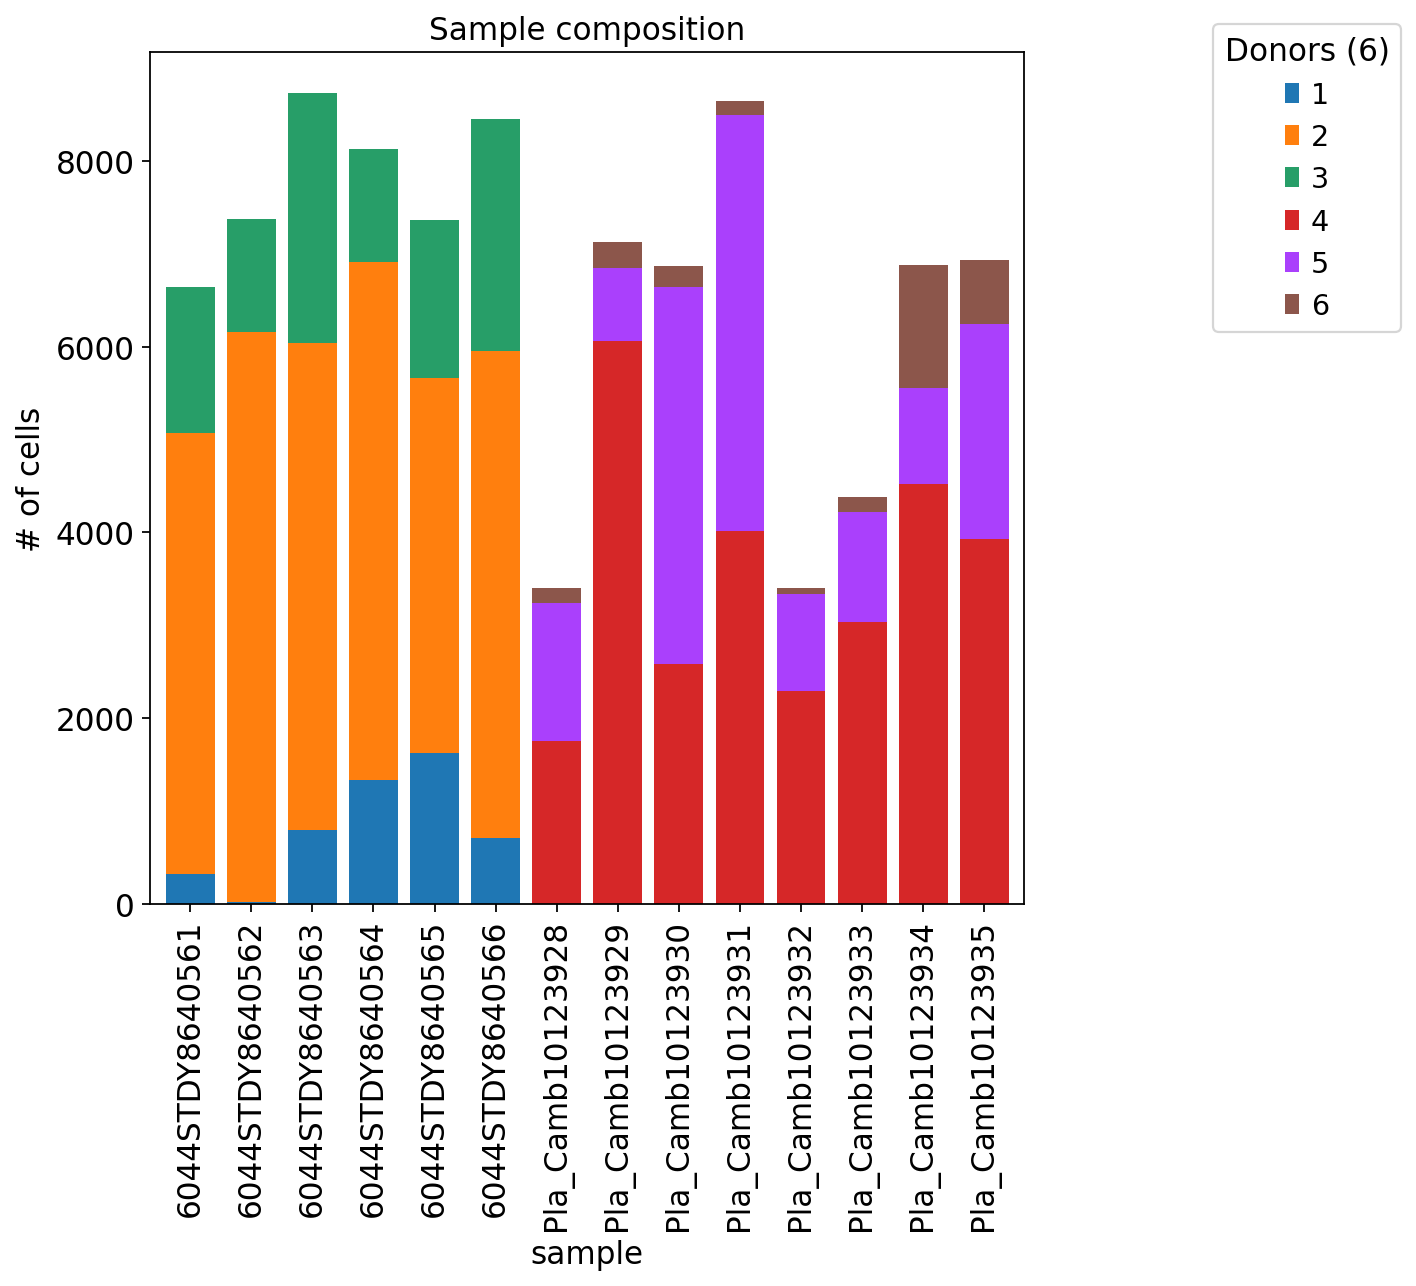

In [74]:
# this is for final cells only

ax = df_stats.plot.bar(stacked=True, figsize=(7,7), width=0.8)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles,
          labels, title='Donors (6)',
          bbox_to_anchor=(1.20, 1.05))

ax.set_xticklabels(labels=['6044STDY8640561', '6044STDY8640562', '6044STDY8640563',
       '6044STDY8640564', '6044STDY8640565', '6044STDY8640566',
       'Pla_Camb10123928', 'Pla_Camb10123929', 'Pla_Camb10123930',
       'Pla_Camb10123931', 'Pla_Camb10123932', 'Pla_Camb10123933',
       'Pla_Camb10123934', 'Pla_Camb10123935'])
ax.tick_params(axis='x', rotation=90)

# to turn off the grid
plt.grid(b=None)

plt.title('Sample composition')
plt.ylabel('# of cells')
plt.xlabel('sample')

#plt.savefig('./figures/sample_composition_all_samples_by_donor_20210518_final_preprocessing.pdf',
#           bbox_inches='tight')

In [75]:
save_path

'/lustre/scratch117/cellgen/team292/aa22/adata_objects/202105_troph_organoids_exp_1_2/'

In [76]:
adata.write(save_path + 'adata_raw_filtered.h5ad')

... storing 'time_point' as categorical
... storing 'activation_status' as categorical
... storing 'media' as categorical
... storing 'sample' as categorical
... storing 'dataset' as categorical
... storing 'technique' as categorical
... storing 'experiment' as categorical
... storing 'souporcell_assignment' as categorical
... storing 'donor' as categorical
... storing 'gene_ids-0' as categorical
... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical
... storing 'gene_ids-1' as categorical
... storing 'feature_types-1' as categorical
... storing 'genome-1' as categorical
... storing 'gene_ids-10' as categorical
... storing 'feature_types-10' as categorical
... storing 'genome-10' as categorical
... storing 'gene_ids-11' as categorical
... storing 'feature_types-11' as categorical
... storing 'genome-11' as categorical
... storing 'gene_ids-12' as categorical
... storing 'feature_types-12' as categorical
... storing 'genome-12' as categorical
... storing 'gen

In [5]:
# reading
adata = sc.read(save_path + 'adata_raw_filtered.h5ad')

In [77]:
adata

AnnData object with n_obs × n_vars = 94357 × 23281
    obs: 'n_genes', 'time_point', 'activation_status', 'media', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'experiment', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'donor'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6'